# Wafer-Die Optimization

The goal of this notebook is to find the optimal number of dies that can be placed on a specific wafer. The user has control over a few different parameters. **The algorithm now automatically optimizes both grid placement and test die placement to maximize deliverable dies while using your specified number of test dies.**

### Input parameters: 
- Wafer size (diameter)
- Wafer Edge Exclusion (WEE)
- Dicing Lane Spacing
- Die size (length, width)
- Scan configuration (columns, rows)
- **Number of test dies per scan block**

### Output Values:
- Die count
- Wafer Utilization
- Optimal X-offset
- Optimal Y-offset
- **Optimal test die placement for your specified count**
- X & Y Layout (Odd/Even)
- Diagram of Wafer

### New Optimization Features:
- **Grid Offset Optimization**: Finds the best X/Y offsets to maximize total dies on wafer
- **Test Die Placement Optimization**: For your specified number of test dies, finds the optimal placement to maximize deliverable dies
- **User-Controlled Test Die Count**: You specify exactly how many test dies you want per scan block (0 to dies_per_scan)
- **Comprehensive Search**: Tests all possible placements of your specified test die count to find the absolute maximum deliverable die count

### Kernel installation
- Use python 3.10.x
- Select "create a Python virtual environment" (Visual Studio Code)
- If you are versed in Conda, then use that, otherwise select **venv**

### Running in Jupyter
- For conda, first use `conda install ipykernel -c conda forge`
- Then use `python -m ipykernel install --user --name=wafer`
- Restart Jupyter Notebook and your kernel should show up

### How to Use this Notebook **IMPORTANT!!!!**
- Run each cell in order
- **ONLY** input parameters in Section 2
- Set `num_test_dies` to your desired number of test dies per scan block
- No other code needs to be changed
- The algorithm will automatically find the optimal placement for your specified test die count
- Once cell 1 has been run once, there is no need to run it again (ONLY run the imports when restarting kernel)

## 1. Installs and Imports

In [ ]:
pip install shapely matplotlib pandas

In [3]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
from collections import defaultdict

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from shapely.geometry import Point, box

## 2. Input Parameters:
Change variables below

**Important:** You can now specify exactly how many test dies you want per scan block using the `num_test_dies` parameter. The algorithm will find the optimal placement of that exact number of test dies to maximize your deliverable dies.

**Test Die Configuration:**
- `num_test_dies`: Specify exactly how many test dies you want per scan block (0 to dies_per_scan)
- `test_positions`: Fallback positions if optimization fails (but the algorithm will find better placements)

**How it works:**
- The algorithm will try all possible combinations of placing exactly `num_test_dies` test dies within each scan block
- It finds the placement that maximizes deliverable dies while using your specified number of test dies
- If `num_test_dies = 0`, no test dies will be placed (maximum deliverable dies)
- If `num_test_dies = dies_per_scan`, all dies in each scan become test dies

Resolution is for how in-depth the search should be. The lower the number the more it'll check offsets. But be warned that lowering the number will result in longer run-times


In [25]:
# Project Name
project_name = "ruby"

# wafer
wafer_diameter = 200 # mm
wee = 3             # mm

# die
die_w = 10           # mm, die width
die_h = 12           # mm, die height
trench = 0.1         # mm, dicing lane

# scan configuration
dies_per_scan = 20     # number of dies in each scan
scan_cols = 5
scan_rows = 4

assert scan_cols * scan_rows == dies_per_scan, "scan_cols*scan_rows must equal dies_per_scan"

# test die configuration
num_test_dies = 1     # number of test dies you want per scan block
test_positions = [(0, scan_rows-1)]  # fallback positions if optimization fails

# Validate that num_test_dies is reasonable
assert num_test_dies >= 0, "num_test_dies must be non-negative"
assert num_test_dies <= dies_per_scan, f"num_test_dies ({num_test_dies}) cannot exceed dies_per_scan ({dies_per_scan})"

# grid search resolution
res_x = 1
res_y = 1

## 3. Transformed Quantities
Do not change any of the code in any cells from here

In [26]:
# true radii
full_radius   = wafer_diameter / 2.0       # physical wafer edge
usable_radius = full_radius - wee          # inside this all dies must fit
wafer = Point(0,0).buffer(usable_radius)

# effective die size
eff_die_w = die_w + trench
eff_die_h = die_h + trench

# grid spacing
step_x = eff_die_w
step_y = eff_die_h

## 4. Grid Generation and Filtering

In [27]:
def generate_dies(offset_x, offset_y):
    """
    Returns a list of dicts for dies fully inside wafer:
      - x,y      : center coords
      - i,j      : global grid indices
      - orient_x,y: 'even'/'odd' based on i,j
    """
    xs = np.arange(-usable_radius + eff_die_w/2 + offset_x,
                   usable_radius,
                   step_x)
    ys = np.arange(-usable_radius + eff_die_h/2 + offset_y,
                   usable_radius,
                   step_y)
    dies = []
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            rect = box(x - eff_die_w/2, y - eff_die_h/2,
                       x + eff_die_w/2, y + eff_die_h/2)
            if wafer.contains(rect):
                dies.append({
                    'x': x, 'y': y,
                    'i': i, 'j': j,
                    'orient_x': 'odd'  if i % 2 else 'even',
                    'orient_y': 'odd'  if j % 2 else 'even'
                })
    return dies

## 5. Optimized Search (Grid Offset + Test Die Placement)

In [28]:
def calculate_deliverable_dies(dies_list, test_pos_list):
    """
    Calculate deliverable dies for a given die layout and test positions.
    Returns (deliverable_count, test_die_count, edge_dies, inside_dies)
    """
    # Clear any old flags
    for d in dies_list:
        for key in ('is_test','sx','sy','li','lj'):
            d.pop(key, None)
    
    # Compute block & local indices
    for d in dies_list:
        d['sx'] = d['i'] // scan_cols
        d['sy'] = d['j'] // scan_rows
        d['li'] = d['i'] % scan_cols
        d['lj'] = d['j'] % scan_rows
    
    # Bucket dies into scan blocks
    scans = defaultdict(list)
    for d in dies_list:
        scans[(d['sx'], d['sy'])].append(d)
    
    # Tag test-dies by explicit test_positions
    test_die_count = 0
    for group in scans.values():
        for (li, lj) in test_pos_list:
            for die in group:
                if die['li']==li and die['lj']==lj:
                    if not die.get('is_test', False):
                        die['is_test'] = True
                        test_die_count += 1
                    break
    
    # Count edge vs inside dies
    unique_i = sorted({d['i'] for d in dies_list})
    unique_j = sorted({d['j'] for d in dies_list})
    if len(unique_i) > 0 and len(unique_j) > 0:
        min_i, max_i = unique_i[0], unique_i[-1]
        min_j, max_j = unique_j[0], unique_j[-1]
        edge_dies = sum(1 for d in dies_list if d['i'] in (min_i,max_i) or d['j'] in (min_j,max_j))
    else:
        edge_dies = 0
    
    inside_dies = len(dies_list) - edge_dies
    deliverable = len(dies_list) - test_die_count
    
    return deliverable, test_die_count, edge_dies, inside_dies

# Generate all possible test positions for the specified number of test dies
from itertools import combinations

if num_test_dies == 0:
    # No test dies - just use empty list
    all_test_positions = [[]]
    print("No test dies specified - maximizing deliverable dies")
elif num_test_dies == dies_per_scan:
    # All dies are test dies - only one configuration
    all_test_positions = [[(li, lj) for li in range(scan_cols) for lj in range(scan_rows)]]
    print(f"All {dies_per_scan} dies per scan will be test dies")
else:
    # Generate all combinations of num_test_dies positions within scan block
    all_positions = [(li, lj) for li in range(scan_cols) for lj in range(scan_rows)]
    all_test_positions = [list(combo) for combo in combinations(all_positions, num_test_dies)]
    print(f"Testing {len(all_test_positions)} different ways to place {num_test_dies} test dies per scan block...")

# First, find the best grid offset
best_count = -1
best_off   = (0.0, 0.0)
best_dies  = None

oxs = np.arange(0, step_x, res_x)
oys = np.arange(0, step_y, res_y)

print("Optimizing grid offset...")
for ox in oxs:
    for oy in oys:
        current = generate_dies(ox, oy)
        cnt = len(current)
        if cnt > best_count:
            best_count = cnt
            best_off   = (ox, oy)
            best_dies  = current

# Now optimize test die placement for maximum deliverable dies
print(f"Optimizing placement of {num_test_dies} test dies per scan block...")
best_deliverable = -1
best_test_positions = test_positions[:num_test_dies] if num_test_dies > 0 else []  # fallback
best_test_count = 0
best_edge_dies = 0
best_inside_dies = 0

# Test each possible test position configuration
for test_pos in all_test_positions:
    # Make a copy of the dies to avoid modifying the original
    dies_copy = [d.copy() for d in best_dies]
    
    deliverable, test_count, edge_dies, inside_dies = calculate_deliverable_dies(dies_copy, test_pos)
    
    if deliverable > best_deliverable:
        best_deliverable = deliverable
        best_test_positions = test_pos
        best_test_count = test_count
        best_edge_dies = edge_dies
        best_inside_dies = inside_dies

# Apply the best configuration
best_x, best_y = best_off
dies = best_dies
total_positions = best_count

# Apply the optimal test positions
for d in dies:
    for key in ('is_test','sx','sy','li','lj'):
        d.pop(key, None)

for d in dies:
    d['sx'] = d['i'] // scan_cols
    d['sy'] = d['j'] // scan_rows
    d['li'] = d['i'] % scan_cols
    d['lj'] = d['j'] % scan_rows

scans = defaultdict(list)
for d in dies:
    scans[(d['sx'], d['sy'])].append(d)

test_die_count = 0
for group in scans.values():
    for (li, lj) in best_test_positions:
        for die in group:
            if die['li']==li and die['lj']==lj:
                if not die.get('is_test', False):
                    die['is_test'] = True
                    test_die_count += 1
                break

edge_dies = best_edge_dies
inside_dies = best_inside_dies

print(f"\nOptimization Results:")
print(f"Best grid offsets → X={best_x:.3f} mm, Y={best_y:.3f} mm")
print(f"Total die positions on wafer: {total_positions}")
print(f"Requested test dies per scan: {num_test_dies}")
print(f"Optimal test die positions: {best_test_positions}")
print(f"Maximum deliverable dies: {best_deliverable}")
print(f"Test dies reserved: {test_die_count}")
print(f"Edge dies: {edge_dies}")
print(f"Inside dies: {inside_dies}")

Testing 20 different ways to place 1 test dies per scan block...
Optimizing grid offset...
Optimizing placement of 1 test dies per scan block...

Optimization Results:
Best grid offsets → X=6.000 mm, Y=3.000 mm
Total die positions on wafer: 211
Requested test dies per scan: 1
Optimal test die positions: [(3, 3)]
Maximum deliverable dies: 202
Test dies reserved: 9
Edge dies: 21
Inside dies: 190


In [29]:
# collect unique grid indices among the final dies
unique_i = sorted({ d['i'] for d in dies })
unique_j = sorted({ d['j'] for d in dies })

num_cols = len(unique_i)
num_rows = len(unique_j)

scan_num_cols = math.ceil(num_cols / scan_cols)
scan_num_rows = math.ceil(num_rows / scan_rows)

orientation_cols = 'even' if scan_num_cols % 2 == 0 else 'odd'
orientation_rows = 'even' if scan_num_rows % 2 == 0 else 'odd'

print(f"Scan Column Orientation: {scan_num_cols} ({orientation_cols})")
print(f"Scan Row Orientation: {scan_num_rows} ({orientation_rows})")
print(f"Using optimized test positions: {best_test_positions}")

Scan Column Orientation: 4 (even)
Scan Row Orientation: 4 (even)
Using optimized test positions: [(3, 3)]


## 6. Deliverable Cells

In [30]:
# The test die placement has already been optimized in the previous section
# This cell now just reports the results

print(f"Test dies reserved: {test_die_count}")
print(f"Edge dies: {edge_dies}")
print(f"Inside dies: {inside_dies}")
print(f"Optimal test die positions used: {best_test_positions}")

Test dies reserved: 9
Edge dies: 21
Inside dies: 190
Optimal test die positions used: [(3, 3)]


In [31]:
deliverable = total_positions - test_die_count
utilization = deliverable * (eff_die_w * eff_die_h) / (math.pi * usable_radius**2) * 100

# filtered grid-dimensions & parity
num_cols    = len({d['i'] for d in dies})
num_rows    = len({d['j'] for d in dies})
orient_cols = 'even' if num_cols % 2 == 0 else 'odd'
orient_rows = 'even' if num_rows % 2 == 0 else 'odd'

print(f"Total positions:  {total_positions}")
print(f"Deliverable dies: {deliverable}")
print(f"Utilization:      {utilization:.1f}%")

Total positions:  211
Deliverable dies: 202
Utilization:      83.5%


## 7. Plot Final

Saved image to:  ruby_20250711_112728_layout.png
Saved metrics to: ruby_20250711_112728_metrics.txt


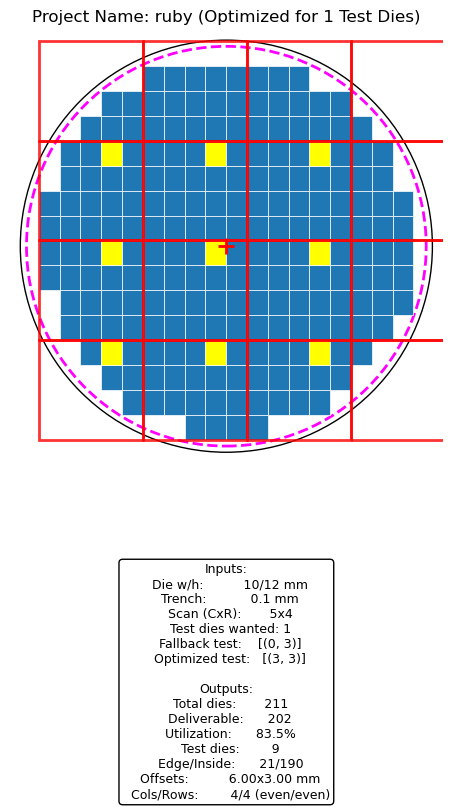

In [32]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from shapely.geometry import box
from datetime import datetime

def unique_filename(base, ext):
    """Generate a unique filename by appending a suffix if needed."""
    i = 0
    while True:
        suffix = f"_{i}" if i > 0 else ""
        fname = f"{base}{suffix}.{ext}"
        if not os.path.exists(fname):
            return fname
        i += 1

# Recompute radii
full_radius   = wafer_diameter / 2.0
usable_radius = full_radius - wee

# Compute origin and pitch for the die-grid
origin_x = -usable_radius + eff_die_w/2 + best_x
origin_y = -usable_radius + eff_die_h/2 + best_y
pitch_x  = step_x
pitch_y  = step_y

# Recompute summary metrics
total_positions = len(dies)
deliverable     = total_positions - test_die_count
utilization     = deliverable * (eff_die_w * eff_die_h) / (math.pi * usable_radius**2) * 100

# Prepare metrics text
metrics_txt = [
    "Inputs:",
    f"  Die w/h:          {die_w}/{die_h} mm",
    f"  Trench:           {trench} mm",
    f"  Scan (CxR):       {scan_cols}x{scan_rows}",
    f"  Test dies wanted: {num_test_dies}",
    f"  Fallback test:    {test_positions}",
    f"  Optimized test:   {best_test_positions}",
    "",
    "Outputs:",
    f"  Total dies:       {total_positions}",
    f"  Deliverable:      {deliverable}",
    f"  Utilization:      {utilization:.1f}%",
    f"  Test dies:        {test_die_count}",
    f"  Edge/Inside:      {edge_dies}/{inside_dies}",
    f"  Offsets:          {best_x:.2f}x{best_y:.2f} mm",
    f"  Cols/Rows:        {scan_num_cols}/{scan_num_rows} ({orientation_cols}/{orientation_rows})"
]

# Create figure
fig, ax = plt.subplots(figsize=(6, 8), constrained_layout=True)

# Draw wafer and WEE
ax.add_patch(plt.Circle((0,0), full_radius,    fill=False, edgecolor='black', linewidth=1,))
ax.add_patch(plt.Circle((0,0), usable_radius,  fill=False, edgecolor='magenta', linestyle='--', linewidth=2))

# Plot dies & test‐dies
for d in dies:
    rect = box(d['x']-eff_die_w/2, d['y']-eff_die_h/2, d['x']+eff_die_w/2, d['y']+eff_die_h/2)
    xr, yr = rect.exterior.xy
    ax.fill(xr, yr, facecolor=('yellow' if d.get('is_test') else 'C0'), edgecolor='white', linewidth=0.5)

# Draw wafer center cross
ax.plot(0, 0, marker='+', color='red', markersize=12, markeredgewidth=2)

# Draw full‐cell scan boundaries in high‐contrast red
max_sx = max(d['sx'] for d in dies)
max_sy = max(d['sy'] for d in dies)
for sx in range(max_sx + 1):
    for sy in range(max_sy + 1):
        x0c = origin_x + sx * scan_cols * pitch_x
        y0c = origin_y + sy * scan_rows * pitch_y
        x0  = x0c - eff_die_w/2
        y0  = y0c - eff_die_h/2
        w   = scan_cols * pitch_x
        h   = scan_rows * pitch_y
        ax.add_patch(mpatch.Rectangle(
            (x0, y0), w, h,
            fill=False, edgecolor='red', linewidth=2, alpha=0.8
        ))

# Add metrics & inputs box below wafer
ax.text(
    0.5, -0.15,
    "\n".join(metrics_txt),
    transform=ax.transAxes,
    ha='center', va='top',
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
)

# Final formatting
ax.set_aspect('equal')
ax.set_xlim(-full_radius * 1.05, full_radius * 1.05)
ax.set_ylim(-full_radius * 1.2, full_radius * 1.05)
ax.axis('off')
# ax.legend(loc='upper right')
ax.set_title(label=f"Project Name: {project_name} (Optimized for {num_test_dies} Test Dies)")

# Save image and metrics only
stamp      = datetime.now().strftime("%Y%m%d_%H%M%S")
base       = f"{project_name}_{stamp}"
img_fname  = unique_filename(f"{base}_layout", "png")
txt_fname  = unique_filename(f"{base}_metrics", "txt")

fig.savefig(img_fname, dpi=150, bbox_inches='tight')
with open(txt_fname, 'w') as f:
    f.write("\n".join(metrics_txt))

print(f"Saved image to:  {img_fname}")
print(f"Saved metrics to: {txt_fname}")

plt.show()